# Simple FRET ratio calculation for multichannel, multifov .nd2 files.

### Basic workflow:
1. Import image stack
2. Initial segmentation is based on mode.
3. Segmentation (fine-tune) based on user input threshold value.
4. Mask creation, application and ratio calculation.
5. Save image.

# To do:
## - implement flatfield correction
## - Multiple file input formats

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import microfilm.microplot
from microfilm.dataset import MultipageTIFF
from microfilm.dataset import ND2
from microfilm.dataset import Nparray
from microfilm.dataset import TIFFSeries
from pims import ND2_Reader
from nd2reader import ND2Reader  #pure python implementation
from timeit import default_timer as timer

# to set a theme:       jt -t <theme-name>
# to restore original:  jt -r
# to restart jupyter:   !jt -r

In [4]:
# pims
def read_nd2_pim(file_path):
    '''convert .nd2 to nd array, return it with list with names of axes'''
    with ND2_Reader(file_path) as images:
        axes = images.axes
        images.bundle_axes = axes
        images.iter_axis = axes
        for img in images:
            pass
    return img, axes, images.metadata

# pure python
def read_nd2_pyt(file_path):
    '''convert .nd2 to nd array, return it with list with names of axes'''
    with ND2Reader(file_path) as images:
        axes = images.axes
        images.bundle_axes = axes
        images.iter_axis = axes
        for img in images:
            pass
    return img, axes, images.metadata

In [5]:
basic_path = "/Users/kobusvanunen/Documents/General Files/PERTZ_position/"
nd2_path   = "MY_DATA/MONCH/2021_05_21_FRET-drugs/RhoA2G_JLY_02/"
filename   = "RhoA2G_JLY_02.nd2"

In [6]:
### pure Python .nd2 reader

# start = timer()
# raw, axes, metadata = read_nd2_pyt(basic_path+nd2_path+filename)
# end = timer()

# channels = dict(zip(metadata["channels"], range(len(metadata["channels"]))))    

# print(end - start) # Time in seconds
# print(channels)

# # Transform the np.array to correct format.

# # [y,x,c,t,fov] -> [x,y,c,t,fov]
# old_pos = [0] #where axes are
# new_pos = [1] #where they should be
# raw = np.moveaxis(raw,old_pos,new_pos)
# print(raw.shape)
# print(type(raw))

In [7]:
### Pims .nd2 reader

start = timer()
raw, axes, metadata = read_nd2_pim(basic_path+nd2_path+filename)
end = timer()

names = []
for x in range(3):
    names.append(metadata['plane_'+str(x)]['name'])

channels = dict(zip(names, range(len(names))))    

print(end - start) # Time in seconds
print(names)
print(channels)

# Transform the np.array to correct format.

# [y,x,c,t,fov] -> [x,y,c,t,fov]
old_pos = [0] #where axes are
new_pos = [1] #where they should be
raw = np.moveaxis(raw,old_pos,new_pos)
print(raw.shape)
print(type(raw))

/Users/kobusvanunen/anaconda3/envs/splitmask/lib/python3.9/site-packages/pims/api.py:119: UserWarning: 'ND2_Reader' has been renamed to 'ND2Reader_SDK' and will beremoved in future pims versions. Please use the new name, or try out the pure-Python one named `ND2Reader`.
  warn("'ND2_Reader' has been renamed to 'ND2Reader_SDK' and will be"
/Users/kobusvanunen/anaconda3/envs/splitmask/lib/python3.9/site-packages/pims/base_frames.py:472: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


12.228108685000002
['DMD-mCherry', 'mTFP1_FRET_donor', 'FRET_acceptor']
{'DMD-mCherry': 0, 'mTFP1_FRET_donor': 1, 'FRET_acceptor': 2}
(1024, 1024, 3, 200, 4)
<class 'pims.frame.Frame'>


In [89]:
### Import .tif image sequence (folders!)


In [90]:
### Import .tif files per channel (files)

In [ ]:
# Raw output must be 'raw' files with (x,y,c,t,fov)



In [8]:
# Define different timeseries channels
actin = raw[:,:,channels["DMD-mCherry"],:,:]
CFP = raw[:,:,channels["mTFP1_FRET_donor"],:,:]
FRET = raw[:,:,channels["FRET_acceptor"],:,:]

channel = FRET

# Background substraction based on first 5 bins of intensity histogram.

def bg_calculation(image):
    hist, bins = np.histogram(image, bins=50)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
#    plt.bar(center, hist, align='center', width = width)
#    plt.ylim(0,450000)
#    plt.xlim(0,750)
    bg = np.mean(bins[0:4])
    return bg, #plt.show(

# Actual background substraction
def background_sub(image, bg):
    global bg_mask
    bg_z_image = image - bg
    bg_mask = np.zeros_like(bg_z_image)
    bg_mask[bg_z_image > 0] = 1
    bg_z_image = bg_mask*bg_z_image
    bg_z_image = bg_z_image.astype(np.float32) 
    return bg_z_image

def bg_correct(image):
    bg_calc = bg_calculation(image)
    corr_im = background_sub(image,bg_calc[0])
    return corr_im

def stack_corr(channel):
#    print(channel.shape)
    new_image = []
    for frame in range(channel.shape[2]):
        new_image.append(bg_correct(channel[:,:,frame]))   

    corr_image = np.asarray(new_image).astype(np.int16)
    corr_image_2 = np.where(corr_image<0, 0, corr_image)
#    print(corr_image_2.shape)
#    print(type(corr_image_2[0,1,1]))
#    plt.imshow(corr_image_2[0,:,:])
    return corr_image_2


def fov_corr(stack):
    all_ch = []
    for ch in range(stack.shape[2]):
         if ch < stack.shape[2]:
            print("Channel"+ str(ch))
            all_ch.append(stack_corr(stack[:,:,ch,:]))
    print("Channels done!")
    all_ch = np.asarray(all_ch).astype(np.int16)
    all_ch.shape
    return all_ch

def multistack_corr(stack):
    res = []
    for fov in range(stack.shape[4]):
        if fov < stack.shape[4]:
            print("Field of View:"+ str(fov))
            res.append(fov_corr(stack[:,:,:,:,fov]))
    print("Field of views done!")
    results = np.asarray(res).astype(np.int16)
    results.shape
    return results

result = multistack_corr(raw)

global i
i = 0

Field of View:0
Channel0
Channel1
Channel2
Channels done!
Field of View:1
Channel0
Channel1
Channel2
Channels done!
Field of View:2
Channel0
Channel1
Channel2
Channels done!
Field of View:3
Channel0
Channel1
Channel2
Channels done!
Field of views done!


0
(4, 3, 200, 1024, 1024)


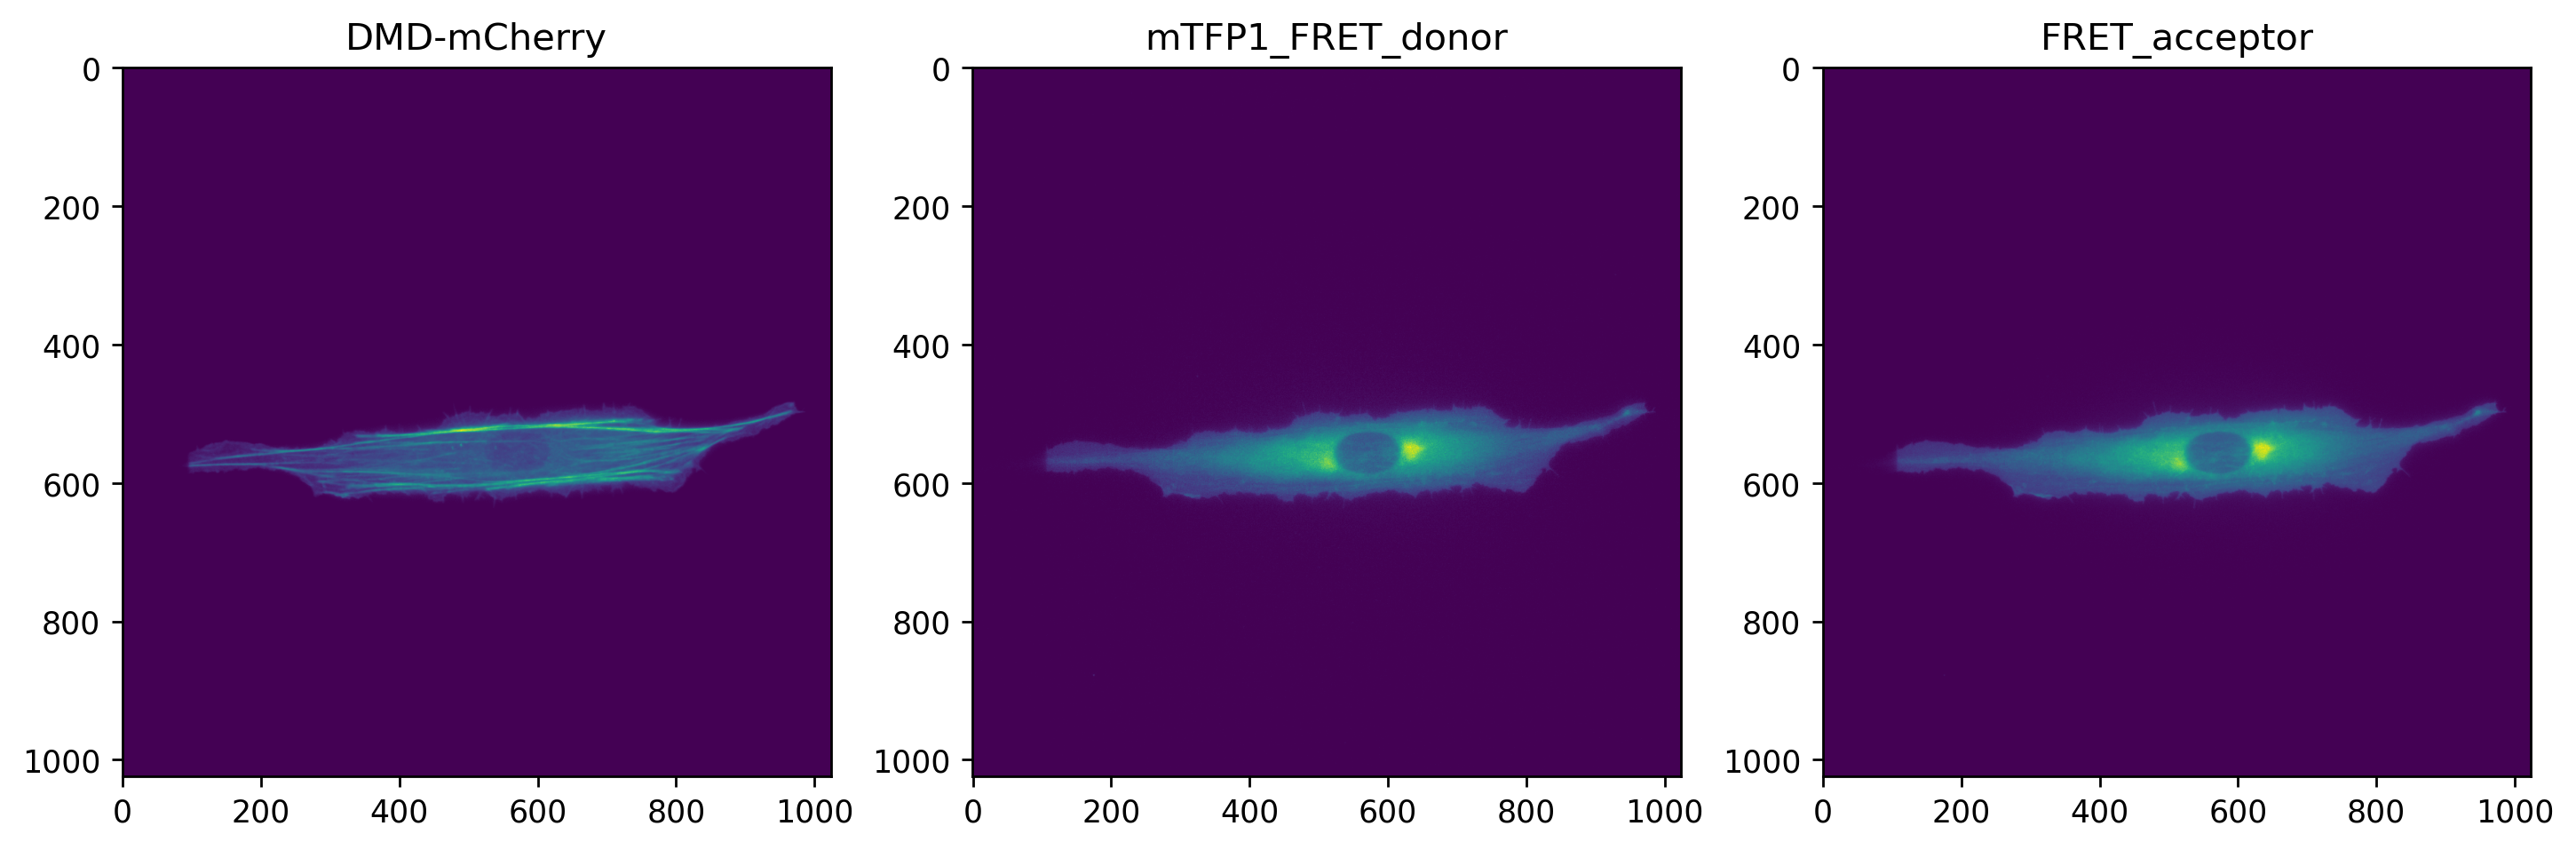

In [69]:
# Define parameters for interactive thresholding.
# Visual Check: i, results and the individual channels.

fov     = i
#ch      = channels["DMD-mCherry"]
ch      = channels["mTFP1_FRET_donor"]
#ch      = channels["FRET_acceptor"]  
frame   = 5

print(i)
print(result.shape)
n_channels = len(channels)

fig, axs = plt.subplots(figsize=(14, 5), ncols=n_channels,dpi = 250)
for k, v in channels.items():
    channel = result[fov,v,frame,:,:]
    axs[v].imshow(channel)
    axs[v].set_title(k)
plt.show()

In [84]:
# Interactive widget to fine-tune the background threshold. Click 'Accept Threshold' to proceed. 

from ipywidgets import interactive, IntSlider, IntRangeSlider, Button, Layout, GridBox, ButtonStyle
import ipywidgets as ipw
from IPython.display import Javascript, display

image_in = result[fov,ch,frame,:,:]
print(i)
print(image_in.shape)

# Thresholding function going over all the pixels 1 by 1 and checking for val_max:
def thresholding(image, limit, val_max):    
    new_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel = image.item(i,j)
            new_image[i,j] = val_max if pixel > limit else pixel
    return new_image

# Plot widget:
def plot_plane(t):
    plt.figure(figsize=(10,10))
    plt.imshow(thresholding(image_in,t,val_max))
    plt.show()
    
def run_range_FA(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1,'+ 
                        'IPython.notebook.get_selected_index()+3)'))
    
val_max = np.max(image_in[:,:])
val_min = np.min(image_in[:,:])

interactive_plot = interactive(plot_plane, t = IntSlider(min=val_min,max=val_max,step=5,value=200,
                                                         continuous_update = False),grid_area='main');
#interactive_plot = interactive(plot_plane, t = IntRangeSlider(min=val_min,max=val_max,step=5,description='Threshold:',value=[0,200],continuous_update = False));  <--- if, use "limit[1]" in thresholding function.
output = interactive_plot.children[-1]
output.layout.height = '500px'

b1 = Button(description='Accept Threshold', button_style='danger', grid_area='sidebar')
b1.style.button_color = 'lightgreen'
b1.on_click(run_range_FA)

ipw.GridBox(children=[interactive_plot, b1],
#ipw.GridBox(children=[interactive_plot],
        layout=Layout(
            width='100%',
            grid_template_columns='50% 25%',
            grid_template_areas='''"main sidebar"''')
       )

0
(1024, 1024)


GridBox(children=(interactive(children=(IntSlider(value=200, continuous_update=False, description='t', max=171…

<IPython.core.display.Javascript object>

In [85]:
# Thresholding based on slider above:
manual_threshold = interactive_plot.kwargs['t']
print(manual_threshold)
print(image_in.shape)
print(result.shape)

200
(1024, 1024)
(4, 3, 200, 1024, 1024)


In [87]:
# Creating mask for manually thresholded pixels 

masks = []
for frame in range(result.shape[2]):
    image_mask = result[fov,ch,frame,:,:] > manual_threshold
    masks.append(image_mask)
    mask = np.asarray(masks).astype(np.int8)
print(mask.shape)
print(mask.max())
print(mask.min())

(200, 1024, 1024)
1
0


In [142]:
# Mask all channels, calculate ratio and save results

# result shape: (4, 3, 200, 1024, 1024).
m_CFP   = result[fov,1,:,:,:] * mask
m_FRET  = result[fov,2,:,:,:] * mask
m_actin = result[fov,0,:,:,:] * mask
ratio   = m_FRET / m_CFP
ratio   = ratio.astype(np.float32)

### Save ratio
#io.imsave(basic_path+nd2_path+filename+"ratio_FOV_"+str(i)+".tif",ratio)

### Increase i: go to cell to produce mask for next Field of View
#i=i+1
#display(Javascript("Jupyter.notebook.execute_cells([7])"))

/var/folders/2t/tqz_70hd15q6g6898jclrj140000gn/T/ipykernel_63684/2290404710.py:7: RuntimeWarning: invalid value encountered in true_divide
  ratio   = m_FRET / m_CFP


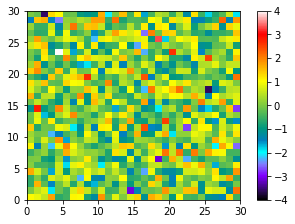

vispy.color.colormap.Colormap

In [92]:
### Making the MM colormap for Ratio images ###

# Two options: with matplotlib or with Vispy (needed for Napari) 

from vispy.color import colormap
from vispy.color import ColorArray
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd

def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

df = pd.read_csv("/Users/kobusvanunen/Documents/General Files/PERTZ_position/MY_DATA/MONCH/CODE/LUT_MM.csv")

red   = df["Red"].array
green = df["Green"].array
blue  = df["Blue"].array

N = 256
vals = np.ones((N, 4))
vals[:, 0] = red / 256
vals[:, 1] = green / 256
vals[:, 2] = blue / 256

# MM made with matplotlib colormap:
cmp_plt  = ListedColormap(vals)
# MM made with vispy Colormap:
cmp_napa = colormap.Colormap(ColorArray(vals))
# MM made as conversion from matplotlib colormap to vispy Colormap:
cmp_napa2 = colormap.MatplotlibColormap(cmp_plt)

plot_examples([cmp_plt])

type(cmp_napa)

In [146]:
import napari

try:
    if viewer:
        viewer.close()
except:
    print("viewer already closed or never opened")
    
### Prepare array for Napari viewing.
np.nan_to_num(ratio, nan=0)
ratio = ratio*1000
ratio = ratio.astype(np.uint16)

### Run this to open napari with an image
viewer = napari.view_image(ratio, name = "FRET Ratio", colormap= ("MM",cmp_napa))
viewer.add_image(result[0,0,:,:,:], name = "Actin")

viewer already closed or never opened


<Image layer 'Actin' at 0x1960ce370>

In [ ]:
df = pd.read_csv("XXX/LUT_MM.csv")

red   = df["Red"].array
green = df["Green"].array
blue  = df["Blue"].array

N = 256
vals = np.ones((N, 4))
vals[:, 0] = red / 256
vals[:, 1] = green / 256
vals[:, 2] = blue / 256

cmp_napa = colormap.Colormap(ColorArray(vals))

viewer = napari.view_image(XXX, colormap= ("MM",cmp_napa))